In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import time
from utils import set_seed, load_dataset, plot_feature_maps, plot_training_progress, evaluate_model
from transform import TensorAugment, SimpleResize
from models import WDMClassifierTiny,WDMClassifierMedium
import h5py

In [3]:
cdm_model='IllustrisTNG'

cdm_file=f'/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/{cdm_model}/Maps_Mtot_{cdm_model}_LH_z=0.00.npy'
wdm_file='/n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/WDM/boxes/Maps_Mtot_IllustrisTNG_WDM_z=0.00.npy'

cdm_galaxy = ' 

In [4]:
# Sample indices
all_indices = random.sample(range(15000), 10000)
random.shuffle(all_indices)

val_test_transform = SimpleResize(
    size=(256, 256),
    apply_log=True  # Keep log scale
)

test_dataset = load_dataset(all_indices, transform=val_test_transform, cdm_file=cdm_file, wdm_file=wdm_file)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, 
                         num_workers=1, pin_memory=True)

Loading CDM data from /n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mtot_IllustrisTNG_LH_z=0.00.npy...
CDM data shape: (15000, 256, 256)
Loading WDM data from /n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/WDM/boxes/Maps_Mtot_IllustrisTNG_WDM_z=0.00.npy...
WDM data shape: (15360, 256, 256)
Created dataset with 20000 samples


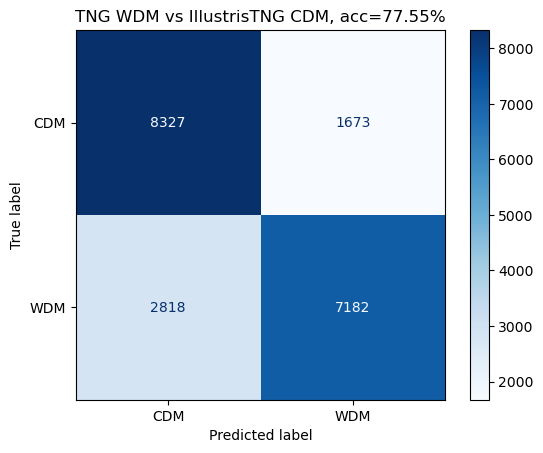

/n/home02/msliu/.conda/envs/env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


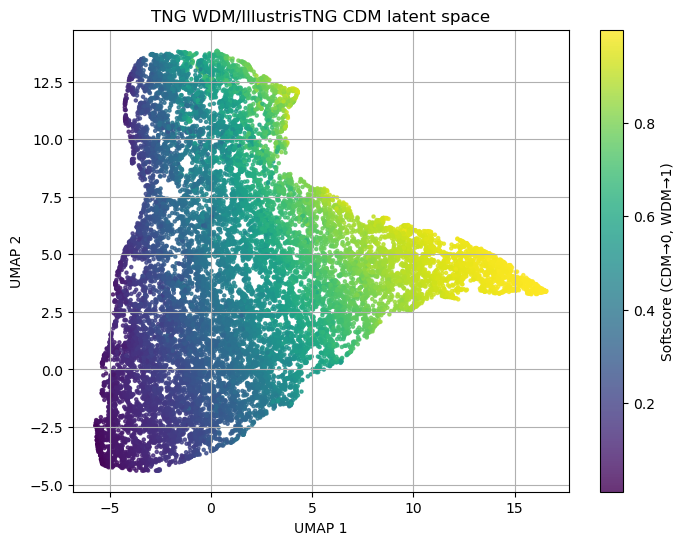

In [5]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
import umap.umap_ as umap

model_type = 'medium'

# --- Set Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load Model ---
model = WDMClassifierMedium().to(device)
checkpoint = torch.load("best_cnn_model_blur_0_medium.pt", map_location=device, weights_only=True)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# --- Inference and Feature Extraction ---
all_preds, all_labels, features, softscores = [], [], [], []

with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)

        # Feature extraction
        feats = model.features(x)
        pooled = nn.AdaptiveAvgPool2d((1, 1))(feats)  # [B, 128, 1, 1]
        flat_feats = torch.flatten(pooled, 1)         # [B, 128]

        # Classifier
        logits = model.classifier[3](flat_feats).squeeze(1)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        # Store outputs
        features.append(flat_feats.cpu())
        softscores.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

features = torch.cat(features, dim=0).numpy()
softscores = np.array(softscores)
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
acc = accuracy_score(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["CDM", "WDM"])
disp.plot(cmap="Blues")
plt.title(f"TNG WDM vs {cdm_model} CDM, acc={acc*100:.2f}%")
plt.savefig(f'cm_WDMClassifierMedium_{cdm_model}.png')
plt.show()

# --- UMAP Projection ---
reducer = umap.UMAP(n_components=2, random_state=42)
umap_results = reducer.fit_transform(features)

# --- UMAP Plot ---
plt.figure(figsize=(8, 6))
sc = plt.scatter(umap_results[:, 0], umap_results[:, 1],
                 c=softscores, cmap="viridis", alpha=0.8,s=5)
plt.title(f"TNG WDM/{cdm_model} CDM latent space")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(sc, label="Softscore (CDM→0, WDM→1)")
plt.grid(True)
plt.savefig(f'umap_softscore_WDMClassifierMedium_{cdm_model}.png')
plt.show()

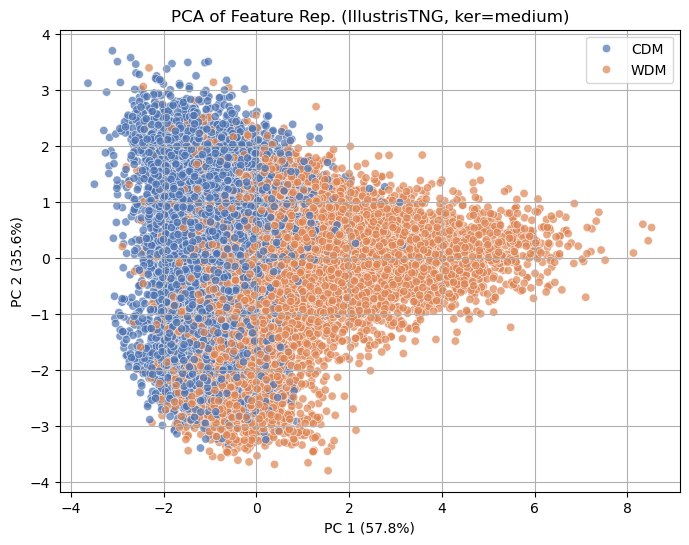

In [8]:
from sklearn.decomposition import PCA

# --- PCA Plot ---
pca = PCA(n_components=2)
pca_results = pca.fit_transform(features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_results[:, 0], y=pca_results[:, 1],
                hue=["CDM" if int(lbl)==0 else "WDM" for lbl in all_labels],
                palette="deep", alpha=0.7)
plt.title(f"PCA of Feature Rep. ({cdm_model}, ker={model_type})")
plt.xlabel(f"PC 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.legend()
plt.grid(True)
plt.savefig(f'pca_{cdm_model}_{model_type}.png')
plt.show()


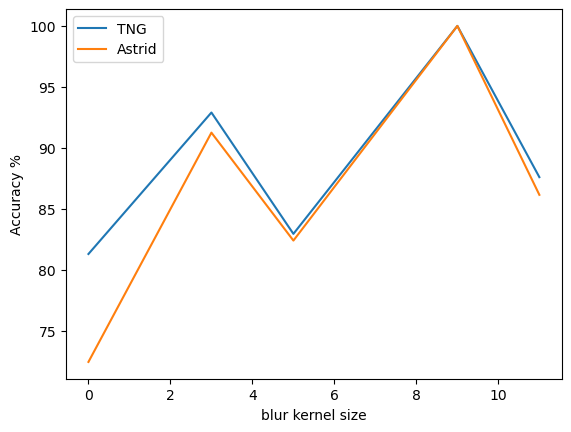

In [34]:
tng=[81.3,92.9,82.95,100,87.6]
astrid=[72.45,91.25,82.4,100,86.15]

plt.plot([0,3,5,9,11],tng,label='TNG')
plt.plot([0,3,5,9,11],astrid,label='Astrid')
plt.legend()
plt.ylabel('Accuracy %')
plt.xlabel('blur kernel size')
plt.savefig('acc.png')
plt.show()

In [4]:
import numpy as np
import Pk_library as PKL

# parameters
BoxSize = 25.0     #Mpc/h
MAS     = 'None'  #MAS used to create the delta; 'NGP', 'CIC', 'TSC', 'PCS' o 'None'
threads = 1       #number of openmp threads

cdm_sample = np.load(cdm_file)
# create an empty delta
img = np.log1p(cdm_sample[0])
delta = img - img.mean()

# compute the Pk of that delta
Pk2D = PKL.Pk_plane(delta, BoxSize, MAS, threads)

# get the attributes of the routine
k      = Pk2D.k      #k in h/Mpc
Pk     = Pk2D.Pk     #Pk in (Mpc/h)^2
Nmodes = Pk2D.Nmodes #Number of modes in the different k bins


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.01 seconds


Lowest frequency: 0.30337902366992636
Highest frequency: 45.49512128674168


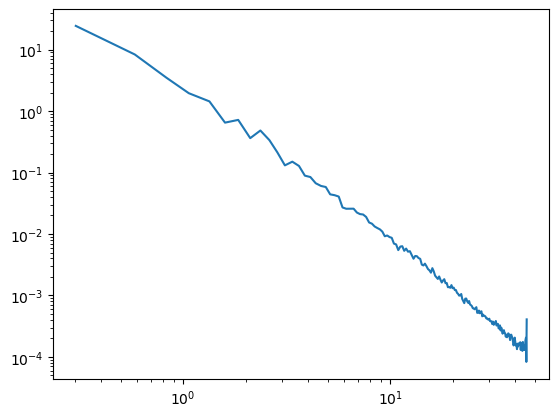

In [5]:
import matplotlib.pyplot as plt
print('Lowest frequency:',np.min(k))
print('Highest frequency:',np.max(k))
plt.loglog(k,Pk)
plt.show()

In [ ]:
from scipy.ndimage import gaussian_filter
delta_smoothed = gaussian_filter(delta,sigma=0.5)
Pk2D_smoothed = PKL.Pk_plane(delta_smoothed, BoxSize, MAS, threads)
k_smoothed      = Pk2D_smoothed.k      #k in h/Mpc
Pk_smoothed     = Pk2D_smoothed.Pk     #Pk in (Mpc/h)^2


Computing power spectrum of the field...
Time to complete loop = 0.00
Time taken = 0.00 seconds


In [6]:
np.shape(Pk)

(181,)

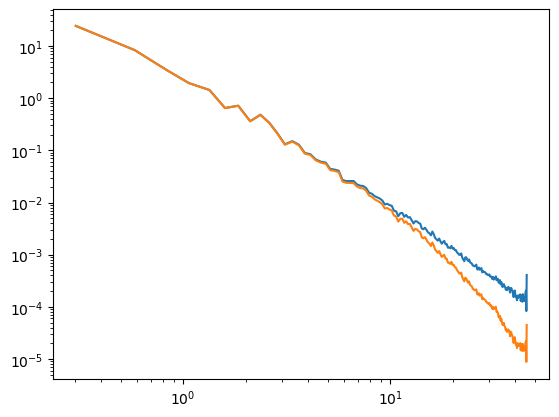

In [8]:
plt.loglog(k,Pk)
plt.loglog(k_smoothed,Pk_smoothed)
plt.show()

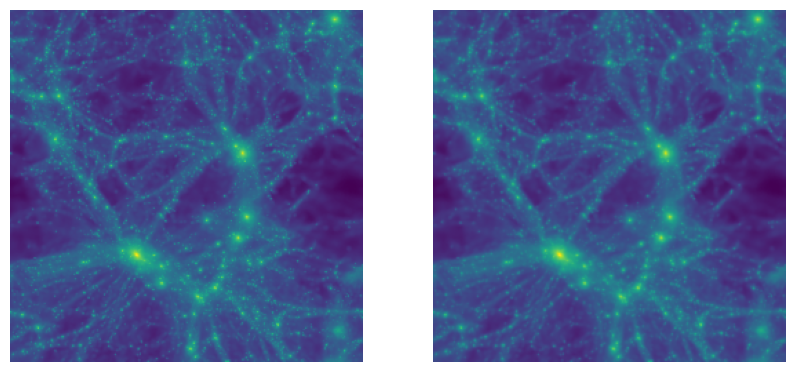

In [9]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(delta)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(delta_smoothed)
plt.axis('off')
plt.show()

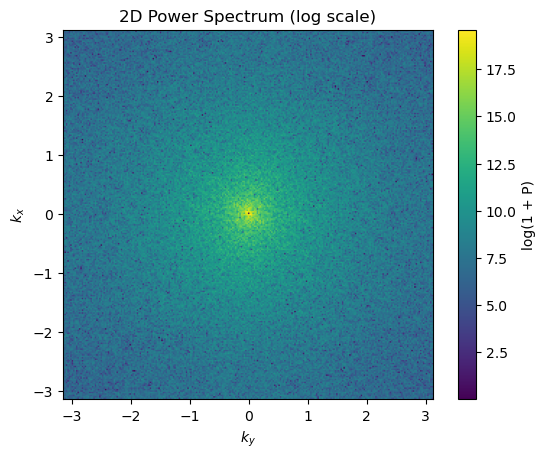

In [11]:
# --- Input ---
Lx, Ly = 256,256  # physical box size in each direction
Nx, Ny = delta.shape   # grid resolution

# --- Fourier Transform ---
fft2 = np.fft.fft2(delta)
fft2_shifted = np.fft.fftshift(fft2)  # center zero frequency
power_spectrum = np.abs(fft2_shifted)**2

# --- Compute Fourier wavenumbers (kx, ky) ---
kx = np.fft.fftfreq(Nx, d=Lx/Nx) * 2 * np.pi  # [1/m]
ky = np.fft.fftfreq(Ny, d=Ly/Ny) * 2 * np.pi
kx_shifted = np.fft.fftshift(kx)
ky_shifted = np.fft.fftshift(ky)
kX, kY = np.meshgrid(kx_shifted, ky_shifted, indexing='ij')
k_mag = np.sqrt(kX**2 + kY**2)  # magnitude of wavevector

# --- Visualize Power Spectrum ---
plt.imshow(np.log1p(power_spectrum), origin='lower',
           extent=[ky_shifted[0], ky_shifted[-1], kx_shifted[0], kx_shifted[-1]])
plt.xlabel('$k_y$')
plt.ylabel('$k_x$')
plt.title('2D Power Spectrum (log scale)')
plt.colorbar(label='log(1 + P)')
plt.show()


In [8]:
np.shape(power_spectrum)

(256, 256)

In [9]:
ky_shifted

array([-3.14159265, -3.11704896, -3.09250527, -3.06796158, -3.04341788,
       -3.01887419, -2.9943305 , -2.96978681, -2.94524311, -2.92069942,
       -2.89615573, -2.87161203, -2.84706834, -2.82252465, -2.79798096,
       -2.77343726, -2.74889357, -2.72434988, -2.69980619, -2.67526249,
       -2.6507188 , -2.62617511, -2.60163142, -2.57708772, -2.55254403,
       -2.52800034, -2.50345665, -2.47891295, -2.45436926, -2.42982557,
       -2.40528188, -2.38073818, -2.35619449, -2.3316508 , -2.3071071 ,
       -2.28256341, -2.25801972, -2.23347603, -2.20893233, -2.18438864,
       -2.15984495, -2.13530126, -2.11075756, -2.08621387, -2.06167018,
       -2.03712649, -2.01258279, -1.9880391 , -1.96349541, -1.93895172,
       -1.91440802, -1.88986433, -1.86532064, -1.84077695, -1.81623325,
       -1.79168956, -1.76714587, -1.74260218, -1.71805848, -1.69351479,
       -1.6689711 , -1.6444274 , -1.61988371, -1.59534002, -1.57079633,
       -1.54625263, -1.52170894, -1.49716525, -1.47262156, -1.44

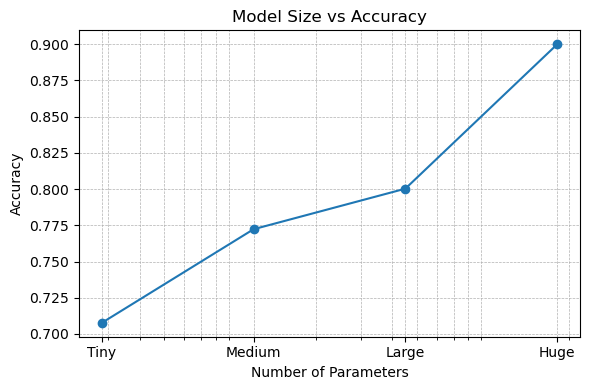

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Number of parameters for each model: 'Tiny', 'Medium', 'Large', 'Huge'
nparam = [282657,1127489,4503681,6791169]
accuracy = [0.7077,0.7723,0.8003, 0.9]

plt.figure(figsize=(6, 4))
plt.plot(nparam, accuracy, marker='o', linestyle='-', color='tab:blue')
plt.title('Model Size vs Accuracy')
plt.xlabel('Number of Parameters')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.xticks(nparam, ['Tiny', 'Medium', 'Large', 'Huge'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
# plt.savefig('model_size_vs_accuracy.png')
plt.show()

In [4]:
class HDF5KeyImageDataset(Dataset):
    """Dataset class for loading CDM/WDM HDF5 files"""
    
    def __init__(self, cdm_path, wdm_path, transform=None):
        self.transform = transform
        self.data_sources = []  # List of (file_type, key_name, sub_index_if_needed)
        
        # Load CDM keys
        self.cdm_file = h5py.File(cdm_path)
        for key in self.cdm_file.keys():
            self.data_sources.append(('cdm', key, None))

        # Load WDM keys
        self.wdm_file = h5py.File(wdm_path)
        for key in self.wdm_file.keys():
            self.data_sources.append(('wdm', key, None))

    def __len__(self):
        return len(self.data_sources)

    def __getitem__(self, idx):
        source, key, sub_idx = self.data_sources[idx]
        h5_file = self.cdm_file if source == 'cdm' else self.wdm_file
        label = 0 if source == 'cdm' else 1
    
        arr = h5_file[key]
        img = arr[:] if sub_idx is None else arr[sub_idx]
    
        # Clean and normalize
        img = np.nan_to_num(img, nan=0.0, posinf=1.0, neginf=0.0)
        img = np.clip(img, 0, None)  # Ensure non-negative
        img = img.astype(np.float32)
    
        if img.max() > 0:
            img = img / img.max()  # Normalize to [0, 1]
    
        # Convert to torch tensor and add channel dim
        img = torch.from_numpy(img).unsqueeze(0)  # shape: [1, H, W]
    
        if self.transform:
            img = self.transform(img)
    
        return img, torch.tensor(label, dtype=torch.float32)

    def __del__(self):
        if hasattr(self, 'cdm_file'):
            self.cdm_file.close()
        if hasattr(self, 'wdm_file'):
            self.wdm_file.close()

def load_multiple_hdf5_datasets(indices, transform=None, base_path='/n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images'):
    """Load multiple HDF5 datasets and concatenate them, skipping corrupted or missing files"""
    datasets = []
    for idx in indices:
        cdm_path = f'{base_path}/CDM/MW_zooms/box_{idx}/CDM/Galaxy_{idx}.hdf5'
        wdm_path = f'{base_path}/WDM/MW_zooms/box_{idx}/CDM/Galaxy_{idx}.hdf5'
        
        if not (os.path.exists(cdm_path) and os.path.exists(wdm_path)):
            print(f"Warning: Skipping missing files for box_{idx}")
            continue
        
        try:
            # Attempt to open files to detect corruption
            with h5py.File(cdm_path, 'r') as f:
                _ = list(f.keys())
            with h5py.File(wdm_path, 'r') as f:
                _ = list(f.keys())
        except Exception as e:
            print(f"Warning: Skipping corrupted file for box_{idx}: {e}")
            continue

        try:
            ds = HDF5KeyImageDataset(cdm_path, wdm_path, transform=transform)
            datasets.append(ds)
        except Exception as e:
            print(f"Warning: Skipping box_{idx} due to dataset init failure: {e}")
    
    if not datasets:
        raise ValueError("No valid datasets found!")
    
    return ConcatDataset(datasets)

In [ ]:
idx = 32
cdm_path = f'/n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/CDM/MW_zooms/box_{idx}/CDM/Galaxy_{idx}.hdf5'
wdm_path = f'/n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/WDM/MW_zooms/box_{idx}/CDM/Galaxy_{idx}.hdf5'

val_test_transform = SimpleResize(
    size=(256, 256),
    apply_log=True  # Keep log scale
)

test_dataset = HDF5KeyImageDataset(cdm_path, wdm_path, transform=val_test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)